<a href="https://colab.research.google.com/github/ryosuke1224-haas/FirstPullRequest/blob/master/DMA_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ecommerce Recommender System with Word2Vec
Avinash Javaji   | 
Daniel Alston   | 
Ignacio Balaguer Serra   | 
Ryosuke Kato

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import gensim
from gensim import corpora, models, similarities
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore')

df = pd.read_excel('https://drive.google.com/uc?export=download&id=1icqOqpQ9fcBIbN2E_dWDJzXaF1Js2laf')

In [ ]:
#Define ntile function
def ntile(a,n):
  q = a.quantile(np.linspace(1/n,1,n))
  output = []
  for i in a:
    if np.isnan(i):
      k = np.nan
    else:
      k = 0
      for j in q:
        if i<=j:
          break
        k += 1
        
    output.append(k)

  return np.array(output)

# Preprocessing & Exploration

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# some data exploration
# top 10 product
print(df['Description'].value_counts()[:10])
print('---------')
# top 10 country
print(df['Country'].value_counts()[:10])

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
ASSORTED COLOUR BIRD ORNAMENT         1501
SET OF 3 CAKE TINS PANTRY DESIGN      1473
PACK OF 72 RETROSPOT CAKE CASES       1385
LUNCH BAG  BLACK SKULL.               1350
NATURAL SLATE HEART CHALKBOARD        1280
Name: Description, dtype: int64
---------
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: Country, dtype: int64


In [ ]:
#average price by country
df[['UnitPrice','Country']].groupby('Country').mean().sort_values(by=['UnitPrice'])

,UnitPrice
Country,
USA,2.216426
Japan,2.276145
Saudi Arabia,2.411000
Iceland,2.644011
Unspecified,2.699574
Netherlands,2.738317
Lithuania,2.841143
Czech Republic,2.938333
Australia,3.220612


In [ ]:
#average Quantity by country
df[['Quantity','Country']].groupby('Country').mean().sort_values(by=['Quantity'])

,Quantity
Country,
USA,3.553265
RSA,6.068966
Unspecified,7.399103
Malta,7.433071
Saudi Arabia,7.500000
European Community,8.147541
Lebanon,8.577778
United Kingdom,8.605486
Italy,9.961395


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
#Appears to be some nulls in CustomerID and Description
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
#Drop these rows from the dataset
df = df.dropna()

In [ ]:
#Number of unique customers
df['CustomerID'].nunique()

4372

In [ ]:
df['Description'].nunique()

3896

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
df['Quantity'].describe()

count    406829.000000
mean         12.061303
std         248.693370
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [ ]:
df['UnitPrice'].describe()

count    406829.000000
mean          3.460471
std          69.315162
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

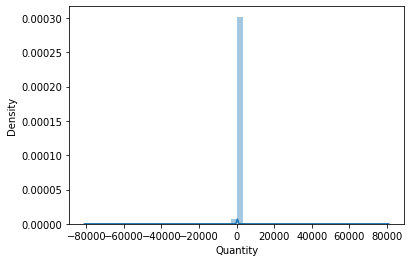

In [ ]:
sns.distplot(df['Quantity'])

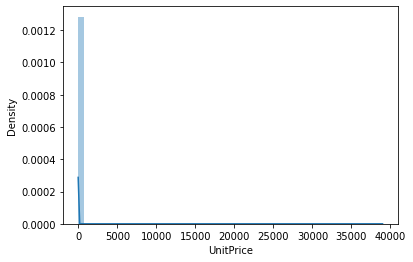

In [ ]:
sns.distplot(df['UnitPrice'])

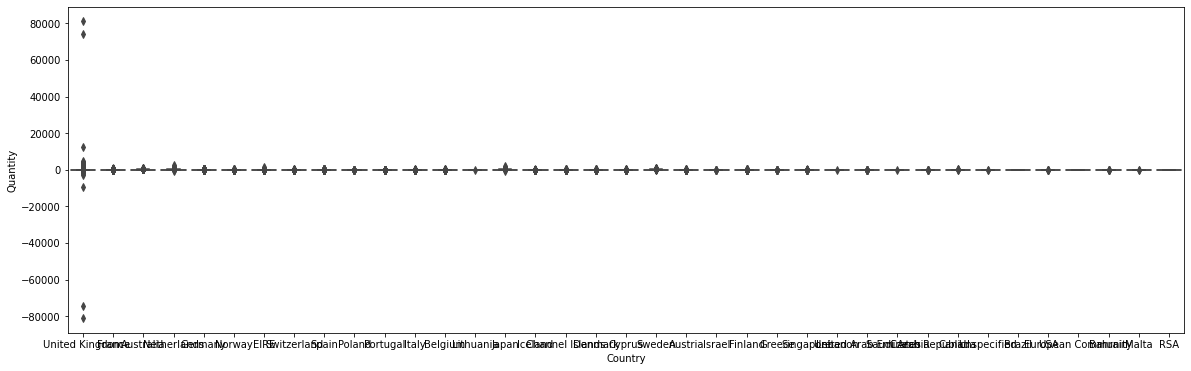

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(x='Country',y='Quantity',data=df)

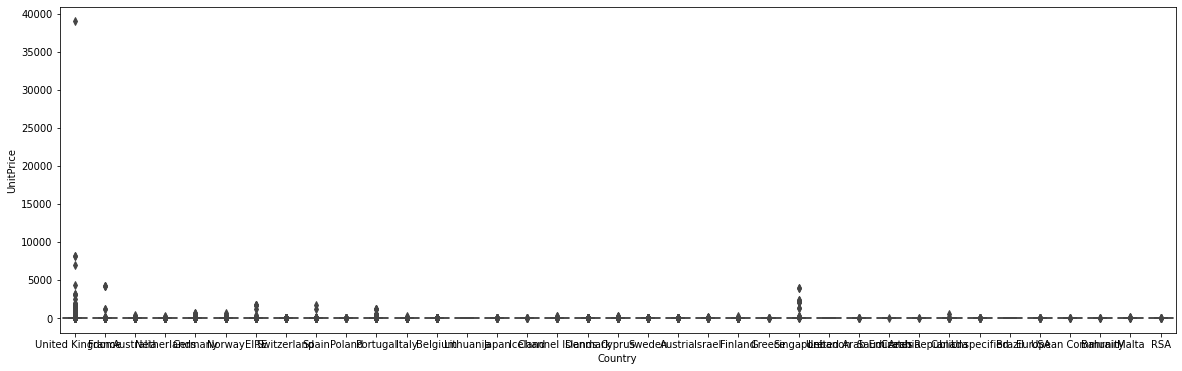

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(x='Country',y='UnitPrice',data=df)

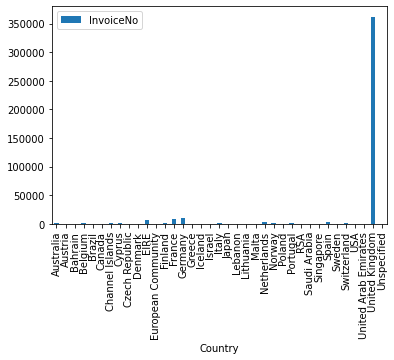

In [ ]:
df[['Country','InvoiceNo']].groupby('Country').count().plot(kind='bar')

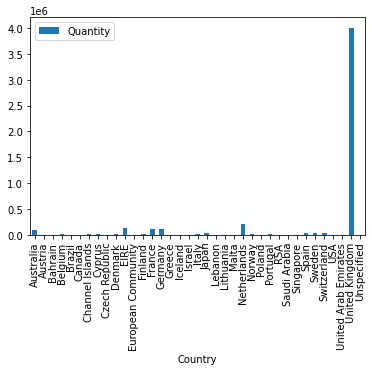

In [ ]:
df[['Country','Quantity']].groupby('Country').sum().plot(kind='bar')

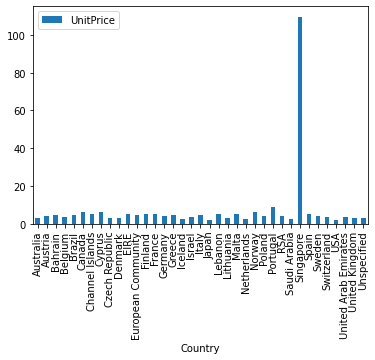

In [ ]:
df[['Country','UnitPrice']].groupby('Country').mean().plot(kind='bar')

In [ ]:
df[['Description','Quantity']].groupby('Description').sum().sort_values(by='Quantity',ascending=False)

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53215
JUMBO BAG RED RETROSPOT,45066
ASSORTED COLOUR BIRD ORNAMENT,35314
WHITE HANGING HEART T-LIGHT HOLDER,34147
PACK OF 72 RETROSPOT CAKE CASES,33409
...,...
PINK POODLE HANGING DECORATION,-12
CRUK Commission,-16
ASSORTED TUTTI FRUTTI ROUND BOX,-24


In [ ]:
df[['Description','InvoiceNo']].groupby('Description').count().sort_values(by='InvoiceNo',ascending=False)

,InvoiceNo
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2070
REGENCY CAKESTAND 3 TIER,1905
JUMBO BAG RED RETROSPOT,1662
ASSORTED COLOUR BIRD ORNAMENT,1418
PARTY BUNTING,1416
...,...
BLUE NEW BAROQUE FLOCK CANDLESTICK,1
IVORY SHELL HEART EARRINGS,1
BLUE PAINTED KASHMIRI CHAIR,1


In [ ]:
df[['Description','UnitPrice']].groupby('Description').mean().sort_values(by='UnitPrice',ascending=False)

,UnitPrice
Description,
DOTCOM POSTAGE,744.147500
PICNIC BASKET WICKER 60 PIECES,649.500000
CRUK Commission,495.839375
Manual,334.425634
REGENCY MIRROR WITH SHUTTERS,156.428571
...,...
LETTER SHAPE PENCIL SHARPENER,0.094634
HOUSE SHAPE PENCIL SHARPENER,0.090208
CARTOON PENCIL SHARPENERS,0.073200


# Product Recommender

In [ ]:
#Break unique customers into a train and validation set
customers_train, customers_test = train_test_split(df['CustomerID'].unique(),test_size=0.1,random_state=42)

#Create train and test datasets
df_train = df[df['CustomerID'].isin(customers_train)]
df_test = df[df['CustomerID'].isin(customers_test)]

In [ ]:
print(len(customers_train))
print(len(customers_test))

3934
438


In [ ]:
#For each customer, create sequence of purchases - training set
purchase_list_train = []

for customer in customers_train:
  purch_list = df_train[df_train['CustomerID']==customer]['Description'].tolist()
  purchase_list_train.append(purch_list)

In [ ]:
#Quick validation: check the first customer in customers_train
customers_train[0]

17007.0

In [ ]:
#Validate the number of instances in the training set for customer 17007
len(df_train[df_train['CustomerID']==17007.0])

53

In [ ]:
#Validate the number of purchases in the purchases list for customer 17007: matches above
len(purchase_list_train[0])

53

In [ ]:
purchase_list_train[0]

['T-LIGHT GLASS FLUTED ANTIQUE',
 'ANTIQUE GLASS HEART DECORATION ',
 'BLUE DRAGONFLY HELICOPTER',
 'STRING OF STARS CARD HOLDER',
 '4 VANILLA BOTANICAL CANDLES',
 'HAND WARMER BABUSHKA DESIGN',
 'BIRD HOUSE HOT WATER BOTTLE',
 'CHARLIE + LOLA RED HOT WATER BOTTLE',
 'SET OF 2 WOODEN MARKET CRATES',
 'OFFICE MUG WARMER POLKADOT',
 'GREEN POLKADOT PLATE ',
 'GREEN POLKADOT BOWL',
 'T-LIGHT GLASS FLUTED ANTIQUE',
 'IVORY GIANT GARDEN THERMOMETER',
 'RED RETROSPOT PICNIC BAG',
 'GLASS JAR ENGLISH CONFECTIONERY',
 'COLOUR GLASS T-LIGHT HOLDER HANGING',
 'PAPER BUNTING WHITE LACE',
 'CHILDRENS CUTLERY SPACEBOY ',
 'FELTCRAFT PRINCESS LOLA DOLL',
 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 'FELTCRAFT HAIRBAND PINK AND BLUE',
 'DINOSAUR KEYRINGS ASSORTED',
 'FELTCRAFT DOLL ROSIE',
 'BAKING SET SPACEBOY DESIGN',
 '10 COLOUR SPACEBOY PEN',
 'BREAD BIN DINER STYLE RED ',
 'SET 6 PAPER TABLE LANTERN HEARTS ',
 '12 PENCILS TALL TUBE POSY',
 'CAKE STAND WHITE TWO TIER LACE',
 'SET OF 9 HEART SHAPED BALL

In [ ]:
#For each customer, create sequence of purchases - test set
purchase_list_test = []

for customer in customers_test:
  purch_list = df_test[df_test['CustomerID']==customer]['Description'].tolist()
  purchase_list_test.append(purch_list)

In [ ]:
#Train a word2vec model
#Starting with a vector size of 10
product_model = gensim.models.Word2Vec(purchase_list_train,min_count=1,size=100,window=10,seed=7)

In [ ]:
#Define a function to give the n-most similar products based a single description
#The use case here is to recommend products to the consumer based on their most recent purchase
def n_most_similar(Description,n):
  return product_model.most_similar(positive=Description)[:n]

In [ ]:
#Find 5 most similar products to first customer in training set's most recent purchase
n_most_similar(purchase_list_train[0][-1],5)

[('ZINC T-LIGHT HOLDER STARS SMALL', 0.9750351309776306),
 ('ZINC HEART FLOWER T-LIGHT HOLDER', 0.9485046863555908),
 ('ZINC WILLIE WINKIE  CANDLE STICK', 0.925857424736023),
 ('LARGE IVORY HEART WALL ORGANISER', 0.9240706562995911),
 ('SILVER HANGING T-LIGHT HOLDER', 0.9143853187561035)]

In [ ]:
#Define a function to give the n-most similar products based on ALL products a consumer has purchased
#The use case here is to recommend products to the consumer based on ALL purchases that they have made
def n_most_similar_list(purchase_list,n):
    product_vec = []
    for i in purchase_list:
      vec = product_model[i]
      product_vec.append(vec)
      mean_vec = np.mean(product_vec, axis=0)

    return product_model.similar_by_vector(mean_vec,n)

In [ ]:
#Find 5 most similar products to first customer in training set's entire purchasing history
n_most_similar_list(purchase_list_train[0],5)

[("DOCTOR'S BAG SOFT TOY", 0.9255819320678711),
 ('GIFT BAG BIRTHDAY', 0.9243654608726501),
 ('CANDY SPOT HAND BAG', 0.921528160572052),
 ('PINK PARTY SUNGLASSES', 0.9207194447517395),
 ('PARTY CONES CARNIVAL ASSORTED', 0.920302152633667)]

In [ ]:
#Let's examine our two functions to see how they're working

#List of purchases for second customer in our training set
list_of_purchases = purchase_list_train[1]

print('Description of products purchased by this customer:\n', list_of_purchases,'\n')

print('Five top recommended products based on most recent purchase:\n', n_most_similar(list_of_purchases[-1],5),'\n')

print('Five top recommended products based on all purchases:\n', n_most_similar_list(list_of_purchases,5),'\n')

Description of products purchased by this customer:
 ['ALARM CLOCK BAKELIKE RED ', 'ALARM CLOCK BAKELIKE CHOCOLATE', 'ANTIQUE SILVER T-LIGHT GLASS'] 

Five top recommended products based on most recent purchase:
 [('ANTIQUE SILVER TEA GLASS ENGRAVED', 0.9371315240859985), ('ZINC T-LIGHT HOLDER STAR LARGE', 0.9061539769172668), ('MULTI COLOUR SILVER T-LIGHT HOLDER', 0.9059759378433228), ('SILVER HANGING T-LIGHT HOLDER', 0.9005051255226135), ('T-LIGHT GLASS FLUTED ANTIQUE', 0.898181140422821)] 

Five top recommended products based on all purchases:
 [('ALARM CLOCK BAKELIKE IVORY', 0.9624022245407104), ('ALARM CLOCK BAKELIKE GREEN', 0.9478898048400879), ('ALARM CLOCK BAKELIKE RED ', 0.9359858632087708), ('ALARM CLOCK BAKELIKE PINK', 0.933828592300415), ('ALARM CLOCK BAKELIKE CHOCOLATE', 0.9284676909446716)] 



In [ ]:
#Test similarity of different products
product_model.similarity('WHITE HANGING HEART T-LIGHT HOLDER','WHITE METAL LANTERN')

0.6493991

In [ ]:
#Analogy product finder - potential for a consumer facing product discovery app
product_model.most_similar(positive=['PINK PARTY SUNGLASSES'],negative=["SILK PURSE BABUSHKA PINK"])[:5]

[('SMALL PARISIENNE HEART PHOTO FRAME ', 0.8574258685112),
 ('PARISIENNE KEY CABINET ', 0.852778971195221),
 ('PARISIENNE JEWELLERY DRAWER ', 0.833879828453064),
 ('LE GRAND TRAY CHIC SET', 0.8250954151153564),
 ('PARISIENNE SEWING BOX', 0.8183879852294922)]

In [ ]:
#Dimensionality reduction for visualization
vector_list = product_model[df_train['Description'].unique().tolist()]

In [ ]:
#Reduce the vector list to 2 dimensions for visualization
from sklearn.manifold import TSNE
data_embed=TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(vector_list)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3865 samples in 0.040s...
[t-SNE] Computed neighbors for 3865 samples in 3.557s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3865
[t-SNE] Computed conditional probabilities for sample 2000 / 3865
[t-SNE] Computed conditional probabilities for sample 3000 / 3865
[t-SNE] Computed conditional probabilities for sample 3865 / 3865
[t-SNE] Mean sigma: 0.130655
[t-SNE] Computed conditional probabilities in 0.385s
[t-SNE] Iteration 50: error = 76.2081528, gradient norm = 0.0448918 (50 iterations in 3.002s)
[t-SNE] Iteration 100: error = 72.8265991, gradient norm = 0.0065684 (50 iterations in 2.805s)
[t-SNE] Iteration 150: error = 72.2407837, gradient norm = 0.0006930 (50 iterations in 2.579s)
[t-SNE] Iteration 200: error = 72.2374496, gradient norm = 0.0002693 (50 iterations in 2.508s)
[t-SNE] Iteration 250: error = 72.2376251, gradient norm = 0.0001424 (50 iterations in 2.514s)
[t-SNE] KL divergence after 250 iterat

In [ ]:
#put the reduced vectors into a dataframe
reduced_df = pd.DataFrame(data_embed,columns=['x','y'])
vocab = pd.DataFrame(list(product_model.wv.vocab))
df_forviz = pd.concat([reduced_df,vocab],axis=1)

In [ ]:
len(vocab)

3865

In [ ]:
df_train['Description'].nunique()

3865

In [ ]:
df_forviz

,x,y,0
0,17.082424,30.582113,T-LIGHT GLASS FLUTED ANTIQUE
1,24.448668,30.485245,ANTIQUE GLASS HEART DECORATION
2,22.327700,29.435087,BLUE DRAGONFLY HELICOPTER
3,43.583981,7.779832,STRING OF STARS CARD HOLDER
4,43.549393,7.628956,4 VANILLA BOTANICAL CANDLES
...,...,...,...
3860,-39.348446,1.454987,TEA TIME TEA TOWELS
3861,-40.775116,2.954615,ASSORTED TUTTI FRUTTI ROUND BOX
3862,-69.063538,12.484281,DOLPHIN WINDMILL
3863,-59.585831,10.525442,BELL HEART ANTIQUE GOLD


In [ ]:
#Adding features to the dataframe to color the visualization; here is avg unit price for each product
product_price_bins = df_train[['Description','UnitPrice']].groupby('Description').mean().reset_index()
product_price_bins['Price_Ntile'] = ntile(product_price_bins['UnitPrice'],5)
product_price_bins

,Description,UnitPrice,Price_Ntile
0,4 PURPLE FLOCK DINNER CANDLES,2.330000,2
1,50'S CHRISTMAS GIFT BAG LARGE,1.247766,1
2,DOLLY GIRL BEAKER,1.243359,1
3,I LOVE LONDON MINI BACKPACK,4.137097,3
4,I LOVE LONDON MINI RUCKSACK,4.150000,3
...,...,...,...
3860,ZINC T-LIGHT HOLDER STARS SMALL,0.838939,0
3861,ZINC TOP 2 DOOR WOODEN SHELF,16.768182,4
3862,ZINC WILLIE WINKIE CANDLE STICK,0.875689,1
3863,ZINC WIRE KITCHEN ORGANISER,7.468182,4


In [ ]:
len(df_train[df_train['Description']==' 4 PURPLE FLOCK DINNER CANDLES'])

32

In [ ]:
#Adding features to the dataframe to color the visualization; here total order count for each product
product_order_bins = df_train[['Description','InvoiceNo']].groupby('Description').count().reset_index()
product_order_bins['Orders_Ntile'] = ntile(product_order_bins['InvoiceNo'],5)
product_order_bins

,Description,InvoiceNo,Orders_Ntile
0,4 PURPLE FLOCK DINNER CANDLES,32,2
1,50'S CHRISTMAS GIFT BAG LARGE,94,3
2,DOLLY GIRL BEAKER,128,3
3,I LOVE LONDON MINI BACKPACK,62,2
4,I LOVE LONDON MINI RUCKSACK,1,0
...,...,...,...
3860,ZINC T-LIGHT HOLDER STARS SMALL,198,4
3861,ZINC TOP 2 DOOR WOODEN SHELF,11,1
3862,ZINC WILLIE WINKIE CANDLE STICK,167,4
3863,ZINC WIRE KITCHEN ORGANISER,11,1


In [ ]:
#Adding features to the dataframe to color the visualization; here is total quantity ordered for each product
total_quantity = df_train[['Description','Quantity']].groupby('Description').sum().reset_index()
total_quantity['Quantity_Ntile'] = ntile(total_quantity['Quantity'],5)
total_quantity

,Description,Quantity,Quantity_Ntile
0,4 PURPLE FLOCK DINNER CANDLES,121,1
1,50'S CHRISTMAS GIFT BAG LARGE,1688,4
2,DOLLY GIRL BEAKER,2309,4
3,I LOVE LONDON MINI BACKPACK,339,2
4,I LOVE LONDON MINI RUCKSACK,1,0
...,...,...,...
3860,ZINC T-LIGHT HOLDER STARS SMALL,4156,4
3861,ZINC TOP 2 DOOR WOODEN SHELF,5,0
3862,ZINC WILLIE WINKIE CANDLE STICK,2352,4
3863,ZINC WIRE KITCHEN ORGANISER,23,0


In [ ]:
df_forviz_temp = df_forviz.merge(product_price_bins,left_on=0,right_on='Description')
df_forviz_temp

,x,y,0,Description,UnitPrice,Price_Ntile
0,17.082424,30.582113,T-LIGHT GLASS FLUTED ANTIQUE,T-LIGHT GLASS FLUTED ANTIQUE,1.231057,1
1,24.448668,30.485245,ANTIQUE GLASS HEART DECORATION,ANTIQUE GLASS HEART DECORATION,1.950000,2
2,22.327700,29.435087,BLUE DRAGONFLY HELICOPTER,BLUE DRAGONFLY HELICOPTER,7.950000,4
3,43.583981,7.779832,STRING OF STARS CARD HOLDER,STRING OF STARS CARD HOLDER,2.950000,3
4,43.549393,7.628956,4 VANILLA BOTANICAL CANDLES,4 VANILLA BOTANICAL CANDLES,1.636364,2
...,...,...,...,...,...,...
3860,-39.348446,1.454987,TEA TIME TEA TOWELS,TEA TIME TEA TOWELS,2.325000,2
3861,-40.775116,2.954615,ASSORTED TUTTI FRUTTI ROUND BOX,ASSORTED TUTTI FRUTTI ROUND BOX,1.650000,2
3862,-69.063538,12.484281,DOLPHIN WINDMILL,DOLPHIN WINDMILL,2.120000,2
3863,-59.585831,10.525442,BELL HEART ANTIQUE GOLD,BELL HEART ANTIQUE GOLD,2.080000,2


In [ ]:
df_forviz_temp2 = df_forviz_temp.merge(product_order_bins,left_on='Description',right_on='Description')
df_forviz_temp2

,x,y,0,Description,UnitPrice,Price_Ntile,InvoiceNo,Orders_Ntile
0,17.082424,30.582113,T-LIGHT GLASS FLUTED ANTIQUE,T-LIGHT GLASS FLUTED ANTIQUE,1.231057,1,246,4
1,24.448668,30.485245,ANTIQUE GLASS HEART DECORATION,ANTIQUE GLASS HEART DECORATION,1.950000,2,30,2
2,22.327700,29.435087,BLUE DRAGONFLY HELICOPTER,BLUE DRAGONFLY HELICOPTER,7.950000,4,27,2
3,43.583981,7.779832,STRING OF STARS CARD HOLDER,STRING OF STARS CARD HOLDER,2.950000,3,12,1
4,43.549393,7.628956,4 VANILLA BOTANICAL CANDLES,4 VANILLA BOTANICAL CANDLES,1.636364,2,110,3
...,...,...,...,...,...,...,...,...
3860,-39.348446,1.454987,TEA TIME TEA TOWELS,TEA TIME TEA TOWELS,2.325000,2,2,0
3861,-40.775116,2.954615,ASSORTED TUTTI FRUTTI ROUND BOX,ASSORTED TUTTI FRUTTI ROUND BOX,1.650000,2,1,0
3862,-69.063538,12.484281,DOLPHIN WINDMILL,DOLPHIN WINDMILL,2.120000,2,1,0
3863,-59.585831,10.525442,BELL HEART ANTIQUE GOLD,BELL HEART ANTIQUE GOLD,2.080000,2,1,0


In [ ]:
df_forviz_final = df_forviz_temp2.merge(total_quantity,left_on='Description',right_on='Description')
df_forviz_final

,x,y,0,Description,UnitPrice,Price_Ntile,InvoiceNo,Orders_Ntile,Quantity,Quantity_Ntile
0,17.082424,30.582113,T-LIGHT GLASS FLUTED ANTIQUE,T-LIGHT GLASS FLUTED ANTIQUE,1.231057,1,246,4,6625,4
1,24.448668,30.485245,ANTIQUE GLASS HEART DECORATION,ANTIQUE GLASS HEART DECORATION,1.950000,2,30,2,295,2
2,22.327700,29.435087,BLUE DRAGONFLY HELICOPTER,BLUE DRAGONFLY HELICOPTER,7.950000,4,27,2,36,1
3,43.583981,7.779832,STRING OF STARS CARD HOLDER,STRING OF STARS CARD HOLDER,2.950000,3,12,1,71,1
4,43.549393,7.628956,4 VANILLA BOTANICAL CANDLES,4 VANILLA BOTANICAL CANDLES,1.636364,2,110,3,817,3
...,...,...,...,...,...,...,...,...,...,...
3860,-39.348446,1.454987,TEA TIME TEA TOWELS,TEA TIME TEA TOWELS,2.325000,2,2,0,2600,4
3861,-40.775116,2.954615,ASSORTED TUTTI FRUTTI ROUND BOX,ASSORTED TUTTI FRUTTI ROUND BOX,1.650000,2,1,0,-24,0
3862,-69.063538,12.484281,DOLPHIN WINDMILL,DOLPHIN WINDMILL,2.120000,2,1,0,1,0
3863,-59.585831,10.525442,BELL HEART ANTIQUE GOLD,BELL HEART ANTIQUE GOLD,2.080000,2,1,0,12,0


In [ ]:
df_forviz_final.to_csv('mytext.tsv',sep='\t',index=False)

In [ ]:
from google.colab.output import eval_js
from IPython.display import Javascript
!git clone https://github.com/CAHLR/d3-scatterplot.git

Cloning into 'd3-scatterplot'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1022 (delta 9), reused 1 (delta 0), pack-reused 1003
Receiving objects: 100% (1022/1022), 1.94 MiB | 4.04 MiB/s, done.
Resolving deltas: 100% (590/590), done.


In [ ]:
def show_port(port, data_file, width=600, height=800):
  display(Javascript("""
  (async ()=>{
    fm = document.createElement('iframe')
    fm.src = await google.colab.kernel.proxyPort(%d) + '/index.html?dataset=%s'
    fm.width = '90%%'
    fm.height = '%d'
    fm.frameBorder = 0
    document.body.append(fm)
  })();
  """ % (port, data_file, height)))

port = 8000
data_file = 'mytext.tsv'
height = 1500

get_ipython().system_raw('cd d3-scatterplot && python3 -m http.server %d &' % port) 
show_port(port, data_file, height)

<IPython.core.display.Javascript object>

#Product Recommender Validation

In [ ]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(product_model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [ ]:
purchase_list_test_2=[]
for i in purchase_list_test:
  if len(i)>1:
    purchase_list_test_2.append(i)

In [ ]:
purchased_item_without_last=[]
last_purchase_item=[]
for i in range(len(purchase_list_test_2)):
  last_purchase=purchase_list_test_2[i][-1]
  last_purchase_item.append(last_purchase)  
  without_last=purchase_list_test_2[i][:-1]
  purchased_item_without_last.append(without_last)

In [ ]:
last_purchase=pd.DataFrame(last_purchase_item)
last_purchase.columns=['last_purchase']

In [ ]:
average_item=[]
for i in purchased_item_without_last:
  average=aggregate_vectors(i)
  average_item.append(average)

In [ ]:
pred = pd.DataFrame()
n=100
for i in range(len(purchase_list_test_2)):
  a=pd.DataFrame(product_model.similar_by_vector(average_item[i],n))
  a=a.drop(1, axis=1).T
  pred=pd.concat([pred, a],axis=0)
pred=pred.reset_index().drop('index', axis=1)
pred=pd.concat([pred,last_purchase],axis=1)

In [ ]:
a=pd.DataFrame()
for i in range(n):
  a['correct_'+str(i)]=(pred[i]==pred['last_purchase']).astype(int)

In [ ]:
a['correct']=a.sum(axis=1)

In [ ]:
pred['correct']=a['correct']

In [ ]:
accuracy_rate = pred['correct'].sum()/len(pred)
accuracy_rate

0.17016317016317017

# Customer Recommender

In [ ]:
#copy dataframe to be used for customer recommender
df2 = pd.DataFrame(df)

#Convert CustomerID to string
df['CustomerID'] = df['CustomerID'].astype(str)

#Break unique products into a train and validation set
products_train, products_test = train_test_split(df2['StockCode'].unique(),test_size=0.1,random_state=42)

#Create train and test datasets
df2_train = df2[df2['StockCode'].isin(products_train)]
df2_test = df2[df2['StockCode'].isin(products_test)]

In [ ]:
print(len(products_train))
print(len(products_test))

3315
369


In [ ]:
#For each product, create sequence of purchases (customers who purchased that product) - training set
customer_list_train = []

for product in products_train:
  cust_list = df2_train[df2_train['StockCode'] == product]['CustomerID'].tolist()
  customer_list_train.append(cust_list)

In [ ]:
#Validate first StockCode
print('First StockCode:', products_train[0])

#Number of instances of stock code 23006 in the training set
print('Number of instances of 23006:', len(df2_train[df2_train['StockCode']==23006]))

#Validate same number in customer list - checks out
print('Number of instances of 23006 in customer list:', len(customer_list_train[0]))

First StockCode: 23006
Number of instances of 23006: 136
Number of instances of 23006 in customer list: 136


In [ ]:
#For each product, create sequence of purchases (customers who purchased that product) - test set
customer_list_test = []

for product in products_test:
  cust_list = df2_test[df2_test['StockCode']==product]['CustomerID'].tolist()
  customer_list_test.append(cust_list)

In [ ]:
df2.head(60)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [ ]:
#Train a word2vec model
#Starting with a vector size of 10
customer_model = gensim.models.Word2Vec(customer_list_train, min_count=1, size=100, window=100,seed=7)

In [ ]:
#Find 5 most similar customers
customer_model.most_similar(positive='17850.0')[:5]

[('17496.0', 0.8699281215667725),
 ('14821.0', 0.8585019111633301),
 ('17732.0', 0.8549244403839111),
 ('15350.0', 0.8437656164169312),
 ('17525.0', 0.8364177346229553)]

In [ ]:
#Seeing this customer's history
df2[df2.CustomerID == '17850.0']['Description'][:10].tolist()

['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'SET 7 BABUSHKA NESTING BOXES',
 'GLASS STAR FROSTED T-LIGHT HOLDER',
 'HAND WARMER UNION JACK',
 'HAND WARMER RED POLKA DOT',
 'HAND WARMER RED POLKA DOT']

In [ ]:
#Seeing this customer's most similar customer's history
most_similar_customer = customer_model.most_similar(positive='17850.0')[:1][0][0]
df2[df2.CustomerID == most_similar_customer]['Description'][:10].tolist()

['ASSORTED COLOURS SILK FAN',
 'RED HANGING HEART T-LIGHT HOLDER',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'PLEASE ONE PERSON METAL SIGN',
 'FAUX FUR CHOCOLATE THROW',
 'GREY HEART HOT WATER BOTTLE',
 'SCOTTIE DOG HOT WATER BOTTLE',
 'CHOCOLATE HOT WATER BOTTLE',
 'HOT WATER BOTTLE BABUSHKA ',
 'HOT WATER BOTTLE I AM SO POORLY']

In [ ]:
#Dimensionality reduction
vector_list = customer_model[df2_train['CustomerID'].unique().tolist()]

In [ ]:
#function to output list of customers likely to buy a product
def potential_customers(stock_code):
  past_cust = df2_train[df2_train['StockCode']==stock_code]['CustomerID'].tolist()[:10]
  potential_customers = customer_model.most_similar(positive=past_cust)[:10]
  return potential_customers

In [ ]:
#Example product
product_id = '84406B'

#Description of the product code we are using
print('Description of produce we are looking at:\n', df2[df2.StockCode == product_id]['Description'][:1].tolist()[0], '\n')

#Testing the function by sending in the product code
potential_cust = potential_customers(product_id)
print('Customers likely to want to buy this product:\n', potential_cust[:5], '\n')

#Purchase history of the most likely next customer
print('Purchase history of', potential_cust[0][0], ':')
print(df2[df2.CustomerID == potential_cust[0][0]]['Description'][:10].tolist())

#Purchase history of the second most likely next customer
print('Purchase history of', potential_cust[1][0], ':')
print(df2[df2.CustomerID == potential_cust[1][0]]['Description'][:10].tolist(), '\n')

Description of produce we are looking at:
 CREAM CUPID HEARTS COAT HANGER 

Customers likely to want to buy this product:
 [('17496.0', 0.8851398229598999), ('17732.0', 0.8789436221122742), ('13065.0', 0.8688386678695679), ('15350.0', 0.8629039525985718), ('14821.0', 0.8598238229751587)] 

Purchase history of 17496.0 :
['ASSORTED COLOURS SILK FAN', 'RED HANGING HEART T-LIGHT HOLDER', 'WHITE HANGING HEART T-LIGHT HOLDER', 'PLEASE ONE PERSON METAL SIGN', 'FAUX FUR CHOCOLATE THROW', 'GREY HEART HOT WATER BOTTLE', 'SCOTTIE DOG HOT WATER BOTTLE', 'CHOCOLATE HOT WATER BOTTLE', 'HOT WATER BOTTLE BABUSHKA ', 'HOT WATER BOTTLE I AM SO POORLY']
Purchase history of 17732.0 :
['VINTAGE CREAM 3 BASKET CAKE STAND', 'CHRISTMAS RETROSPOT HEART WOOD', 'HOME BUILDING BLOCK WORD', 'BATH BUILDING BLOCK WORD', 'FAWN BLUE HOT WATER BOTTLE', 'HOT WATER BOTTLE TEA AND SYMPATHY', 'JUMBO BAG PINK POLKADOT', 'JUMBO BAG RED RETROSPOT', 'DOORMAT RESPECTABLE HOUSE', 'DOORMAT UNION JACK GUNS AND ROSES'] 



In [ ]:
from sklearn.manifold import TSNE
data_embed = TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(vector_list)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4359 samples in 0.047s...
[t-SNE] Computed neighbors for 4359 samples in 4.597s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4359
[t-SNE] Computed conditional probabilities for sample 2000 / 4359
[t-SNE] Computed conditional probabilities for sample 3000 / 4359
[t-SNE] Computed conditional probabilities for sample 4000 / 4359
[t-SNE] Computed conditional probabilities for sample 4359 / 4359
[t-SNE] Mean sigma: 0.529252
[t-SNE] Computed conditional probabilities in 0.398s
[t-SNE] Iteration 50: error = 78.5780029, gradient norm = 0.0000374 (50 iterations in 2.337s)
[t-SNE] Iteration 100: error = 77.9665985, gradient norm = 0.0102175 (50 iterations in 2.658s)
[t-SNE] Iteration 150: error = 77.4517517, gradient norm = 0.0000919 (50 iterations in 2.131s)
[t-SNE] Iteration 200: error = 77.4489822, gradient norm = 0.0005421 (50 iterations in 2.433s)
[t-SNE] Iteration 250: error = 77.3232498, gradient norm = 0.000912

In [ ]:
data_embed

array([[ -3.2651274, -51.947903 ],
       [-27.871796 , -24.800701 ],
       [-37.3478   ,  11.674446 ],
       ...,
       [ 32.463448 ,   0.9489198],
       [ 16.881329 ,  24.681273 ],
       [  1.0924712,  42.38417  ]], dtype=float32)

In [ ]:
vector_list

array([[ 3.0901010e+00, -1.0988375e+00,  1.7203182e+00, ...,
        -8.3690518e-01, -3.4944787e+00,  4.0846545e-01],
       [ 2.1902628e+00,  4.0061903e-01,  3.7500688e-01, ...,
         1.0691415e+00, -1.6061007e+00, -3.0453119e+00],
       [-1.2169340e+00,  7.3985785e-01, -4.7757271e-01, ...,
         2.8783541e+00,  2.9576106e+00, -6.6401708e-01],
       ...,
       [ 6.2205952e-02, -3.1368360e-02, -1.5082472e-02, ...,
        -1.7851096e-02, -2.4746655e-02,  1.2941094e-03],
       [ 1.6513637e-01,  5.4530255e-02, -4.1726362e-02, ...,
        -1.8209267e-02,  1.2869075e-01,  1.7780763e-01],
       [ 3.6217186e-01, -6.7249812e-02, -7.3720431e-01, ...,
         2.9886213e-01,  8.7786549e-01,  3.0212191e-01]], dtype=float32)

In [ ]:
df2_train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df2_train[['CustomerID','Quantity']].groupby('CustomerID').sum().reset_index()['Quantity']

0          0
1       2106
2       1981
3        595
4        169
        ... 
4354      45
4355      42
4356      82
4357    1240
4358    1574
Name: Quantity, Length: 4359, dtype: int64

In [ ]:
reduced_df = pd.DataFrame(data_embed,columns=['x','y'])
vocab = pd.DataFrame(list(customer_model.wv.vocab))
df2_forviz = pd.concat([reduced_df,vocab],axis=1)
df2_forviz['country'] = df2_train[['CustomerID','Country']].groupby('CustomerID').first().reset_index()['Country']
df2_forviz['quantity'] = df2_train[['CustomerID','Quantity']].groupby('CustomerID').sum().reset_index()['Quantity']

df2_train['total_spend'] = df2_train.Quantity * df2_train.UnitPrice
df2_forviz['total_spend'] = df2_train[['CustomerID','total_spend']].groupby('CustomerID').sum().reset_index()['total_spend']
df2_forviz = df2_forviz.rename(columns={0: 'CustomerId'})

In [ ]:
df2_forviz.head()

,x,y,CustomerId,country,quantity,total_spend
0,-3.265127,-51.947903,13089.0,United Kingdom,0,0.00
1,-27.871796,-24.800701,15903.0,Iceland,2106,3755.60
2,-37.347801,11.674446,17841.0,Finland,1981,1652.28
3,-24.507553,-20.963926,13767.0,Italy,595,1687.77
4,45.344040,-2.758820,16912.0,Norway,169,288.40


In [ ]:
df2_forviz.to_csv('mytext2.tsv',sep='\t',index=False)

In [ ]:
def show_port(port, data_file, width=600, height=800):
  display(Javascript("""
  (async ()=>{
    fm = document.createElement('iframe')
    fm.src = await google.colab.kernel.proxyPort(%d) + '/index.html?dataset=%s'
    fm.width = '90%%'
    fm.height = '%d'
    fm.frameBorder = 0
    document.body.append(fm)
  })();
  """ % (port, data_file, height)))

port = 8000
data_file = 'mytext2.tsv'
height = 1600

get_ipython().system_raw('cd d3-scatterplot && python3 -m http.server %d &' % port) 
show_port(port, data_file, height)

<IPython.core.display.Javascript object>

#Customer Recommender Validation

In [ ]:
def aggregate_vectors_cust(customers):
    customer_vec = []
    for i in customers:
        try:
            customer_vec.append(customer_model[i])
        except KeyError:
            continue
        
    return np.mean(customer_vec, axis=0)

In [ ]:
customer_list_test_2=[]
for i in customer_list_test:
  if len(i)>1:
    customer_list_test_2.append(i)

In [ ]:
purchased_cust_without_last=[]
last_purchase_cust=[]
for i in range(len(customer_list_test_2)):
  last_purchase=customer_list_test_2[i][-1]
  last_purchase_cust.append(last_purchase)  
  without_last=customer_list_test_2[i][:-1]
  purchased_cust_without_last.append(without_last)

In [ ]:
last_purchase=pd.DataFrame(last_purchase_cust)
last_purchase.columns=['last_purchase']

In [ ]:
average_cust=[]
for i in purchased_cust_without_last:
  average=aggregate_vectors_cust(i)
  average_cust.append(average)

In [ ]:
pred = pd.DataFrame()
n=100
for i in range(len(customer_list_test_2)):
  a=pd.DataFrame(customer_model.similar_by_vector(average_cust[i],n))
  a=a.drop(1, axis=1).T
  pred=pd.concat([pred, a],axis=0)
pred=pred.reset_index().drop('index', axis=1)
pred=pd.concat([pred,last_purchase],axis=1)

In [ ]:
pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,last_purchase
0,14044.0,18024.0,13291.0,16527.0,17429.0,16450.0,14232.0,17962.0,15201.0,15663.0,17370.0,12977.0,16305.0,16394.0,17696.0,14002.0,14745.0,17263.0,15569.0,15334.0,16918.0,15746.0,14891.0,16794.0,17105.0,17750.0,15829.0,16813.0,13618.0,17248.0,14375.0,15541.0,14716.0,12821.0,15232.0,17695.0,14124.0,17854.0,15342.0,17775.0,...,15700.0,14645.0,17899.0,15752.0,13583.0,13667.0,17923.0,15007.0,17265.0,18147.0,12649.0,16904.0,14408.0,12461.0,15690.0,17873.0,13162.0,16906.0,16041.0,14699.0,13474.0,13959.0,14414.0,18230.0,13194.0,15128.0,17816.0,13355.0,14336.0,12871.0,13762.0,14552.0,13791.0,17298.0,13026.0,17422.0,17935.0,16729.0,17514.0,14096.0
1,14336.0,14232.0,17962.0,13184.0,14401.0,13717.0,16527.0,13524.0,14321.0,16448.0,13618.0,14272.0,13126.0,15315.0,13885.0,17854.0,15932.0,17105.0,15349.0,15663.0,17154.0,13253.0,13140.0,13499.0,15569.0,14918.0,15547.0,14997.0,15746.0,17696.0,16209.0,14375.0,17775.0,17656.0,13675.0,14995.0,13165.0,13427.0,15722.0,14472.0,...,13955.0,16780.0,13233.0,17828.0,16965.0,14576.0,16175.0,16930.0,14177.0,13685.0,13134.0,17514.0,13799.0,14298.0,17560.0,13782.0,13479.0,17172.0,14196.0,15263.0,14167.0,17135.0,15438.0,14883.0,17122.0,17470.0,14924.0,15185.0,13474.0,12556.0,13291.0,16081.0,14064.0,13583.0,13162.0,15717.0,13026.0,17790.0,18069.0,15471.0
2,12674.0,12562.0,12689.0,12656.0,13131.0,12962.0,12518.0,12724.0,12645.0,12598.0,12670.0,12380.0,12397.0,12492.0,12680.0,12620.0,12579.0,12700.0,12395.0,12705.0,12714.0,12379.0,13816.0,12490.0,12362.0,12438.0,12483.0,12721.0,12814.0,12526.0,12474.0,12390.0,12513.0,12583.0,12716.0,12475.0,12637.0,12531.0,12558.0,12701.0,...,12654.0,12664.0,13927.0,17552.0,12626.0,13985.0,12703.0,12593.0,12381.0,12406.0,12398.0,12457.0,18145.0,14533.0,13817.0,14262.0,12372.0,13520.0,12691.0,16648.0,17703.0,14495.0,12678.0,17791.0,12609.0,12384.0,16581.0,15136.0,17295.0,12566.0,13772.0,16999.0,15866.0,13209.0,13296.0,13318.0,12491.0,12662.0,14720.0,14730.0
3,12977.0,13291.0,18024.0,15181.0,13563.0,16527.0,15132.0,16906.0,15577.0,15569.0,13618.0,17921.0,14745.0,13637.0,15985.0,16813.0,16241.0,18064.0,12556.0,14147.0,16041.0,14375.0,12942.0,13611.0,13675.0,15201.0,17229.0,16356.0,14044.0,15976.0,14584.0,14699.0,13263.0,15700.0,17923.0,17946.0,14645.0,16448.0,14162.0,15722.0,...,18193.0,17854.0,14476.0,13479.0,13052.0,16206.0,17873.0,14235.0,15800.0,17105.0,17514.0,15182.0,14690.0,15007.0,17625.0,13561.0,18129.0,15289.0,16529.0,17899.0,16324.0,15523.0,17298.0,14100.0,18032.0,18224.0,14976.0,15026.0,14423.0,15665.0,15980.0,13462.0,15264.0,14801.0,17948.0,13499.0,16120.0,16225.0,12821.0,17491.0
4,13166.0,15709.0,18078.0,13052.0,17781.0,17535.0,17770.0,18280.0,16252.0,17708.0,13402.0,13439.0,16377.0,12881.0,14779.0,13976.0,15388.0,14195.0,14889.0,15528.0,13848.0,12605.0,13404.0,17171.0,13747.0,14012.0,18155.0,13497.0,15554.0,13821.0,13753.0,15945.0,16431.0,17035.0,17969.0,17701.0,14737.0,16030.0,17905.0,18009.0,...,14059.0,16583.0,18061.0,12988.0,17166.0,14633.0,13581.0,15219.0,14672.0,14238.0,15670.0,14625.0,18176.0,15454.0,16499.0,13508.0,14348.0,12574.0,16943.0,15052.0,17236.0,17060.0,14248.0,17749.0,13600.0,15512.0,17881.0,18010.0,15869.0,16217.0,17263.0,17320.0,17923.0,17843.0,17970.0,12564.0,16308.0,12601.0,12468.0,18203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,15048.0,18218.0,15192.0,15810.0,12455.0,16287.0,17118.0,13235.0,17954.0,12580.0,17994.0,12524.0,16113.0,12414.0,12468.0,12557.0,13815.0,12643.0,13509.0,13069.0,13376.0,13330.0,14981.0,13158.0,

In [ ]:
a=pd.DataFrame()
for i in range(n):
  a['correct_'+str(i)]=(pred[i]==pred['last_purchase']).astype(int)

In [ ]:
a['correct']=a.sum(axis=1)

In [ ]:
pred['correct']=a['correct']

In [ ]:
accuracy_rate = pred['correct'].sum()/len(pred)
accuracy_rate

0.12429378531073447